## Description

***Is the SARIMA model useful for stock prediction? If so, when is it useful?***

This GitHub project utilized the yfinance library to import historical stock data for Apple Inc. (AAPL), NVIDIA (NVDA), and Tesla (TSLA). By leveraging this data, SARIMA models were developed for stock price prediction:
 
 **SARIMA Model: Seasonal Autoregressive Integrated Moving Average (SARIMA) model, a time series forecasting method, is implemented to capture the underlying patterns and trends in the stock price data.**

 The Seasonal Autoregressive Integrated Moving Average (SARIMA) model provides a robust framework for predicting stock prices. SARIMA's ability to capture seasonal patterns and cyclic behavior inherent in sequential data, along with its foundation in statistical time series analysis principles, lends credibility to our predictions. The model's interpretable parameters allow for a deeper understanding of the underlying dynamics driving stock price movements. However, it's important to note SARIMA's limitation in capturing external factors such as news events or sudden market shocks, which may impact stock prices but are not directly incorporated into the model. Despite this consideration, SARIMA remains a valuable tool for predicting stock prices based on historical patterns and internal data dynamics.  


Two additional kinds of models were created for the AAPL stock for further analysis:

1. **LSTM Model**: Long Short-Term Memory (LSTM) neural network model is utilized for its ability to effectively learn from sequential data and capture complex patterns in the stock price dynamics.
2. **Combined LSTM and SARIMA Model**: A novel approach combining the strengths of both LSTM and SARIMA models is proposed. This hybrid model aims to enhance prediction accuracy by leveraging the complementary capabilities of each model.

## Objective
The objective of this project is to discover if it is possible to implement a robust SARIMA model to enable accurate prediction of a client's company stock price, leveraging historical data and market trends. The primary aim was to use the predictive insights to formulate strategic investment decisions aimed at maximizing shareholder profit and optimizing portfolio performance. First, it was determined how much historical data was necessary to train the machine learning models for the most accurate predictions. This was done by using metrics for comparison (see section below). Second, it was concluded if this tool is accurate enough for real-world use by analyzing the amount of money gained/lost if this stock was used.

For AAPL, NVDA, and TSLA: Download historical data for the following time ranges and predict stock price for 06-01-2024 to 06-11-2024:

Historical Data Time Ranges:
1. 01-01-2004 to 5-31-2024 
2. 01-01-2010 to 5-31-2024
3. 01-01-2013 to 5-31-2024
4. 01-01-2017 to 5-31-2024
5. 01-01-2019 to 5-31-2024
6. 01-01-2021 to 5-31-2024
7. 01-01-2023 to 5-31-2024

## Metrics Used for Comparison
In order to determine which time range of historical data was best for each stock, the following metrics were used for comparison:
1. p-value: The p-value measures the probability that the observed results (or something more extreme) could have occurred under the null hypothesis.
2. R-squared value: The R-squared value, or coefficient of determination, represents the proportion of variance in the dependent variable that is predictable from the independent variable(s)
3. Root Mean Squared Error (RMSE):  RMSE is a measure of the average magnitude of the errors between predicted values and actual values. It is the square root of the average of the squared differences  between prediction and actual observation.
4. Mean Squared Error (MSE): MSE is the average of the squares of the errors, which are the differences between the actual values and the predicted values.
5. Akaike Information Criterion (AIC): AIC is a measure used for model selection that balances model fit and complexity. It estimates the relative quality of statistical models for a given set of data.
6. Bayesian Information Criterion (BIC): BIC is another criterion for model selection that also balances model fit and complexity, similar to AIC, but with a stronger penalty for models with more parameters.


## Summary Findings

It was determined which time range was best for each stock.

For TSLA, the model with historical data from 01-01-2013 to 05-31-2023 was the best. This model had the least variance between actual and predicted data, the best r-squared value (0.64), and considerably low AIC and BIC values (-16386.14, -16350.39).

AAPL Stock: 
TSLA Stock: 
NVDA Stock:

*how*
## Methodology

In [46]:
# install necessary packages on local machine
%pip install yfinance
%pip install stockstats
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pytz
%pip install statistics
%pip install os
%pip install pyarrow
%pip install pandas_gbq
%pip install statsmodels
%pip install tensorflow
%pip install prophet
%pip install plotly
%pip install statsmodels
%pip install scikit-learn
%pip install pmdarima
%pip install prophet

'\n%pip install yfinance\n%pip install stockstats\n%pip install matplotlib\n%pip install numpy\n%pip install pandas\n%pip install pytz\n%pip install statistics\n%pip install os\n%pip install pyarrow\n%pip install pandas_gbq\n%pip install statsmodels\n%pip install tensorflow\n%pip install prophet\n%pip install plotly\n%pip install statsmodels\n%pip install scikit-learn\n%pip install pmdarima\n%pip install prophet\n'

In [47]:
import yfinance as yf
from stockstats import StockDataFrame as ss
import matplotlib as mp
import numpy as np
import pandas as pd
import pytz
import warnings
import time
import random
import statistics
import pydoc
import os
import pyarrow
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import sqlite3
import pickle
from sklearn.metrics import mean_squared_error, r2_score
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from datetime import date
from prophet import Prophet
import matplotlib.pyplot as graph

'\nimport yfinance as yf\nfrom stockstats import StockDataFrame as ss\nimport matplotlib as mp\nimport numpy as np\nimport pandas as pd\nimport pytz\nimport warnings\nimport time\nimport random\nimport statistics\nimport pydoc\nimport os\nimport pyarrow\nimport statsmodels.api as sm\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout\nfrom tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint\nfrom sklearn.preprocessing import MinMaxScaler\nimport sqlite3\nimport pickle\nfrom sklearn.metrics import mean_squared_error, r2_score\nimport pmdarima as pm\nfrom sklearn.preprocessing import MinMaxScaler\nimport matplotlib.pyplot as plt\nimport pickle as pkl\nfrom datetime import datetime\nfrom datetime import timedelta\nfrom datetime import date\nfrom prophet import Prophet\nimport matplotlib.pyplot as graph\n'

### Download Data for Selected Stock and Time Range (e.g. NVDA)

In [52]:
# ask user for stock ticker and print data
stock_select_str = input("Enter stock ticker: ")
# initial load run
stock_data = yf.download(stock_select_str, start = '2024-04-01', end = '2024-05-31', interval = '1d')

[*********************100%%**********************]  1 of 1 completed


### Print Portion of Downloaded Historical Data and Indicators

In [53]:
stock_df = ss.retype(stock_data)
stock_data[['stochrsi', 'macd', 'mfi']] = stock_df[['stochrsi', 'macd', 'mfi']]
print(stock_data.head())

                 open       high        low      close  adj close     volume  \
Date                                                                           
2024-04-01  90.299004  92.224998  89.204002  90.362999  90.355576  452441000   
2024-04-02  88.447998  90.094002  87.620003  89.452003  89.444656  433064000   
2024-04-03  88.484001  90.374001  88.400002  88.963997  88.956688  370067000   
2024-04-04  90.405998  90.634003  85.879997  85.904999  85.897942  434965000   
2024-04-05  86.865997  88.481003  85.926003  88.008003  88.000778  399678000   

            stochrsi      macd  mfi  
Date                                 
2024-04-01       NaN  0.000000  0.5  
2024-04-02       NaN -0.020439  0.5  
2024-04-03       NaN -0.041176  0.5  
2024-04-04       NaN -0.160043  0.5  
2024-04-05     100.0 -0.137581  0.5  


### Connect to Google BigQuery Service

In [8]:
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

# Import google cloud service account and bigquery
from google.oauth2 import service_account
from google.cloud import bigquery

# Specify google cloud project information
credentials = service_account.Credentials.from_service_account_file(
    '...')
project_id = '...'
client = bigquery.Client(project=project_id, credentials=credentials)
dataset_id = '...'
table_id = '...'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# Specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
load_data = client.load_table_from_dataframe(stock_data, table_path, job_config=load_info)
load_data.result()

'\nSCOPES = [\n    \'https://www.googleapis.com/auth/cloud-platform\',\n    \'https://www.googleapis.com/auth/drive\',\n]\n\n# Import google cloud service account and bigquery\nfrom google.oauth2 import service_account\nfrom google.cloud import bigquery\n\n# Specify google cloud project information\ncredentials = service_account.Credentials.from_service_account_file(\n    \'...\')\nproject_id = \'...\'\nclient = bigquery.Client(project=project_id, credentials=credentials)\ndataset_id = \'...\'\ntable_id = \'...\'\ntable_path = f"{project_id}.{dataset_id}.{table_id}"\n\n# Specify load reqs\nload_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")\nload_data = client.load_table_from_dataframe(stock_data, table_path, job_config=load_info)\nload_data.result()\n'

## Functions


### SARIMA Model Functions

In [54]:
from datetime import datetime
import pandas as pd
def sarima_forecast(model, df, forecast_date, Feature_Scaler):
    print("forecast \n")
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    #Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))

    return df_result

In [55]:
def process_model(stock_transformed):
    print("process model \n")
    sarima_model = pm.auto_arima(stock_transformed["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequency of the cycle (yearly)
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
    
    return sarima_model

In [71]:
import yfinance as yf
import numpy as np

def print_metrics(df_result, model, stock_name):
    stock_ticker = yf.Ticker(stock_name)
    # import actual closing prices into real_values dataframe
    real_values = yf.download(stock_name, end='2024-06-11')
    # calculate AIC and BIC
    aic = model.aic()
    bic = model.bic()
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")

    # Ensure indices match
    #df_result = df_result.loc[real_values.index]
    #df_result.dropna()
    #real_values.dropna()
    df_result = df_result.reindex(real_values.index)


    # calculate RMSE and MSE
    subtract = (real_values.loc['2024-06-01':'2024-06-11', "Close"] - df_result.loc['2024-06-01':'2024-06-11',"Prediction"])
    mse = (subtract ** 2).mean()
    rmse = np.sqrt(mse)
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

    # calculate R-squared
    # actual values - mean of actual values
    ss_total = ((real_values.loc['2024-06-01':'2024-06-11', "Close"] - (real_values.loc['2024-06-01':'2024-06-11', "Close"]).mean()) ** 2).sum()
    # residual sum of squares
    ss_residual = ((real_values.loc['2024-06-01':'2024-06-11', "Close"] - df_result["Prediction"]) ** 2).sum()
    r_squared = 1 - (ss_residual / ss_total)
    print(f"R-squared: {r_squared}")

    # calculate p-value
    import statsmodels.api as sm
    X = sm.add_constant(df_result["Prediction"])
    y = real_values.loc['2024-06-01':'2024-06-11', "Close"]
    print(X)
    print(y)

    # ensure indices match
    X = X.loc[y.index]
    y = y.loc[X.index]

    # fit OLS model (ols regression)
    model_sm = sm.OLS(y, X).fit()
    # extract p-value
    p_value = model_sm.pvalues[1]  # p-value for the 'Prediction' variable
    print(f"P-value: {p_value}")

    

In [57]:
def serialize_deserialize(sarima_model):
    print("serialize \n")
    # Serialize with Pickle and save it as pkl
    with open('sarima_model.pkl', 'wb') as pkl:
        pickle.dump(sarima_model, pkl)

    # Desiarilize the content of the file back into a Python object
    with open('sarima_model.pkl', 'rb') as pkl:
        loaded_model = pickle.load(pkl)

    return loaded_model

In [58]:
def sarima_load(stock_data, feature_scaler):
    # remove any duplicate index
    stock_data = stock_data.loc[~stock_data.index.duplicated(keep='first')]
    # filter only required data
    stock_data = stock_data[['Close']]
    # transform current stock data
    stock_transformed = pd.DataFrame(np.squeeze(feature_scaler.fit_transform(stock_data), axis=1), columns=["Close"], index=stock_data.index)
    # call function to fit a seasonal ARIMA model
    sarima_model = process_model(stock_transformed)
    # call function to serialize / deserialize SARIMA model with pickle
    sarima_model = serialize_deserialize(sarima_model)
    return stock_transformed, sarima_model

### LSTM Model Functions (Additional Analysis)

In [59]:
# LSTM functions

def features_targets(data, feature_length):
    # feature length is the number of time steps in the input sequence
    # targets are the values the model is trying to forecast
    time_step_list, close_label_list = [], []
    
    # iterate through (length of sequential data) to (length of seq data - feature length)
    for i in range(len(data) - feature_length):
        # this will get the vals leading up to the target
        time_steps = data[i : i + feature_length]
        time_step_list.append(time_steps)
        # this will get the target val at this point
        labels = data[i + feature_length]
        close_label_list.append(labels)

    # reshape lists to be suitable for network algo
    time_step_list = np.array(time_step_list).reshape(len(time_step_list), feature_length, 1)
    close_label_list = np.array(close_label_list).reshape(len(close_label_list), 1)

    return time_step_list, close_label_list

In [60]:
def create_model(X, Y, df, data, train_test_slice, scaler):
    # training set: set to train the machine learning model
    # testing set: set used to test model after model has been trained
    # train set is 70% of data, test set is the rest (30%)
    X_train, X_test = X[:-train_test_slice], X[-train_test_slice:]
    Y_train, Y_test = Y[:-train_test_slice], Y[-train_test_slice:]

    # initialize empty model where nodes have input and output with Keras
    model = Sequential()
    # create a bidirectional LSTM: 
    # - 100 cells
    # - return output for input
    # - reduce overfitting w current dropout
    # - specify # of steps for target
    model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1, input_shape=(X_train.shape[1], 1))))
    # provide additional processing with undirectional layer
    model.add(LSTM(50, recurrent_dropout=0.1))
    # add dropout and dense layers
    # randomly sets 20% of inputs to 0 to prevent overfitting
    model.add(Dropout(0.2))
    # create a connected layer with 25 output units
    model.add(Dense(20, activation='elu'))
    model.add(Dropout(0.2))
    # create a connected layer with 10 output units
    model.add(Dense(10))
    # create a connected layer with 1 output unit
    model.add(Dense(1))

    # optimize model using stochastic gradient descent to train model
    # SGD 
    optimize = tf.keras.optimizers.SGD(learning_rate = 0.002)
    # compile model
    model.compile(loss='mean_squared_error', optimizer=optimize)
    # save model weights validation loss improves
    weights = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
    # adjust learning rate when needed
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=0.00001, verbose=1)

    # one epoch completes when the entire training dataset is processed once by the model
    model.fit(X_train, Y_train, epochs=12, batch_size=1, verbose=1, shuffle=False, validation_data=(X_test, Y_test), callbacks=[reduce_lr, weights])
    actual = scaler.inverse_transform(Y_test)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual = np.squeeze(actual, axis=1)
    predictions = np.squeeze(predictions, axis=1)

    #reassign index before it goes into model
    test_df = pd.DataFrame({'Actual': actual, 'Predicted': predictions.flatten()})
    print(test_df)
    #return model, loss, predict, predict_inv, Y_test, scaler

    '''
    # Plotting test set
    graph.plot(df.index[-train_test_slice:], predictions, label="Predicted")
    graph.plot(df.index[-train_test_slice:], actual, label="Actual")
    graph.xlabel('Date')
    graph.ylabel('Stock Price')
    graph.legend()
    graph.savefig('predicted_stock_prices_lstm3_test.png')
    graph.show()
    '''
    return model, X_train, X_test, Y_train, Y_test

In [61]:
def predict_lstm(model, df, future_date, scaler, feature_length=20):
    # iterate through today's date until future date
    for i in range((datetime.strptime(future_date, '%Y-%m-%d') - df.index[-1]).days):
        # specify close values
        feature_column = df['Close'].values
        # pick out last 20 days
        time_steps = feature_column[-feature_length:]
        # reshape array
        time_steps = time_steps.reshape(feature_length, 1)
        # scale array
        time_steps = scaler.transform(time_steps)
        prediction = model.predict(time_steps.reshape(1, feature_length, 1))
        prediction = scaler.inverse_transform(prediction)
        # concatenate results with og dataframe
        df_forecast = pd.DataFrame(prediction, index=[df.index[-1] + timedelta(days=1)], columns=['Close'])
        df = pd.concat([df, df_forecast])
    return df

In [62]:
def create_plot(test, stock_name):
    print("create plot \n")
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(test["Actual"][-120:], color='#1f76b4')
    plt.plot(test["Prediction"], color='darkgreen')
    plt.fill_between(test.index,
                test["Low"],
                test["High"],
                color='k', alpha=.15)

    plt.title(f"SARIMA - Forecast of {stock_name} Stock Price")
    plt.show()

## Step 1: SARIMA Model for TSLA Stock


(EXAMPLE) Predict stock share price for AAPL stock with historical time range 01-01-2013 to 05-31-2024:

In [74]:
import yfinance as yf
stock_select_str1 = input("Enter stock ticker 1: ")
#stock_select_str2 = input("Enter stock ticker 2: ")
#stock_select_str3 = input("Enter stock ticker 3: ")
                       
# initial load run
stock_data = yf.download(stock_select_str, start = '2013-01-01', end = '2024-05-31', interval = '1d')
# scale data
feature_scaler = MinMaxScaler()
# run SARIMA functions for initial load
initial_transformed, initial_model = sarima_load(stock_data, feature_scaler)
#print("initial load returned")
# forecast initial load
initial_df_pred_sarima = sarima_forecast(initial_model, initial_transformed, '2024-06-11', feature_scaler)
print_metrics(initial_df_pred_sarima.tail(11), initial_model, stock_select_str)
#print("IMPORTANT\n")
#print(initial_df_pred_sarima.tail(11))
#print(initial_df_pred_sarima)
plot = create_plot(initial_df_pred_sarima, stock_select_str)
#print(initial_df_pred_sarima["Actual"])
#graph.plot(plot, label = "total predict")
#graph.plot(actual, label = "total actual")
#graph.xlabel('Date')
#graph.ylabel('Stock Price')
#graph.legend()
#graph.savefig('predicted_stock_prices_lstm_total.png')
#graph.savefig('test1.png')
#graph.show()


[*********************100%%**********************]  1 of 1 completed
process model 



### SARIMA model plot diagnostics plot

### SARIMA plot

## Step 2: LSTM
*why?*  

LSTM MODEL:

In [41]:
apple_data = yf.download("AAPL", start = "2020-01-01", interval = '1d')
apple_df_test = apple_data.reset_index()
apple_df = apple_df_test.copy()

[*********************100%%**********************]  1 of 1 completed


In [42]:
scaler = MinMaxScaler()
data_transformed = pd.DataFrame(
    np.squeeze(
        scaler.fit_transform(
            apple_df[["Close"]])), columns=["Close"], index=apple_df.index)

In [43]:
time_step_vals, target_vals = features_targets(data_transformed["Close"].values, 20)

In [44]:
train_vals_cutoff = apple_df.loc[apple_df['Date'] >= '2022-01-01']
slice = train_vals_cutoff.shape[0]


In [45]:
model, X_train, X_test, Y_train, Y_test = create_model(
        time_step_vals, target_vals, apple_df, data_transformed["Close"].values, slice, scaler)

Epoch 1/12
485/485 [==============================] - 11s 20ms/step - loss: 0.0062 - val_loss: 0.0161 - lr: 0.0020
Epoch 2/12
485/485 [==============================] - 9s 19ms/step - loss: 0.0111 - val_loss: 0.0146 - lr: 0.0020
Epoch 3/12
485/485 [==============================] - 9s 18ms/step - loss: 0.0101 - val_loss: 0.0121 - lr: 0.0020
Epoch 4/12
485/485 [==============================] - 9s 18ms/step - loss: 0.0092 - val_loss: 0.0111 - lr: 0.0020
Epoch 5/12
485/485 [==============================] - 8s 17ms/step - loss: 0.0081 - val_loss: 0.0095 - lr: 0.0020
Epoch 6/12
485/485 [==============================] - 8s 18ms/step - loss: 0.0069 - val_loss: 0.0088 - lr: 0.0020
Epoch 7/12
485/485 [==============================] - 8s 17ms/step - loss: 0.0061 - val_loss: 0.0076 - lr: 0.0020
Epoch 8/12
485/485 [==============================] - 8s 17ms/step - loss: 0.0052 - val_loss: 0.0067 - lr: 0.0020
Epoch 9/12
485/485 [==============================] - 8s 17ms/step - loss: 0.0053 - val

In [48]:
total_x = np.concatenate((X_train, X_test), axis = 0)
total_y = np.concatenate((Y_train, Y_test), axis = 0)
final_predict = model.predict(total_x)
final_predict = scaler.inverse_transform(final_predict)
actual = scaler.inverse_transform(total_y)
final_predict = np.squeeze(final_predict, axis = 1)
actual = np.squeeze(actual, axis = 1)

36/36 [==============================] - 0s 6ms/step


### LSTM plot

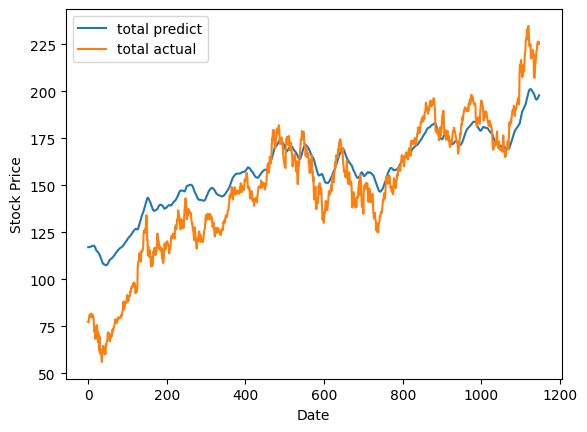

In [49]:
graph.plot(final_predict, label = "total predict")
graph.plot(actual, label = "total actual")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
graph.savefig('test.png')
graph.show()

In [50]:
model.predict(data_transformed[-21:-1].values.reshape(1,20,1))
data = pd.DataFrame(apple_data)
test = predict_lstm(model, data, '2024-02-01', scaler)

1/1 [==============================] - 0s 14ms/step


In [51]:
test.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-16,223.919998,226.830002,223.649994,226.050003,226.050003,44340200
2024-08-19,225.720001,225.990005,223.039993,225.889999,225.889999,40687800
2024-08-20,225.770004,227.169998,225.449997,226.509995,226.509995,30299000
2024-08-21,226.520004,227.979996,225.050003,226.399994,226.399994,34729100
2024-08-22,227.600006,228.339996,224.920105,225.190002,225.190002,18135958


# Q: is this where the combo assessment goes?

# Q: Why does SARIMA only have 1 function, but LSTM has several?

# Q: do you want to output plots as pngs?

## Write to file

In [ ]:

# specify google cloud project information
dataset_id = 'predicted_prices'
table_id = 'SARIMA and LTSM Predicted Prices'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
# enter combined data load_data = client.load_table_from_dataframe(combined data, table_path, job_config=load_info)
load_data.result()

## Summary
** a bit more detail about why a client would need this and what value it would bring to their work **